In [1]:
import scipy as sp
import scipy.interpolate as spip
import scipy.integrate as spin
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# %load ../Tools/Histogram.py
import numpy as np


class Histogram():
    '''
    Class to storage histograms
    '''
    def __init__(self, data=[], nbin=None, minlim=None, maxlim=None,
                 name='default', isotope='default', volume='default',
                 material='default'):
        '''
        Creates an histogram from a given a list (empty by defoult),
        with low and high limits, by defoult are the minimum and
        maximum of de data sample and the bin number, by default
        the number of data squareroot
        '''

        if len(data) == 0:
            if minlim == 'nada' or maxlim == 'nada' or nbin == 'nada':
                auxs = 'In order to build an empty histogram it '
                auxs += 'is needed a minlim, maxlim and nbin'
                raise ValueError(auxs)
                return
            else:
                self.minlim = minlim
                self.maxlim = maxlim
                self.nbin = nbin

        else:
            if minlim is None:
                self.minlim = min(data)
            else:
                self.minlim = minlim
            if maxlim is None:
                self.maxlim = max(data)
            else:
                self.maxlim = maxlim
            if nbin is None:
                self.nbin = int(len(data)**0.5)
            else:
                self.nbin = nbin

        self.binsize = float(self.maxlim-self.minlim)/float(self.nbin)
        self.hist = np.array([])
        self.bins = np.array([])

        self.Build_hist(data)

        self.name = name
        self.isotope = isotope
        self.volume = volume
        self.material = material

    def __add__(self, hist):
        '''
        Suming histograms
        '''

        if not self.minlim == hist.minlim or not self.maxlim == hist.maxlim\
                or not self.nbin == hist.nbin:
            raise ValueError('Histograms are not compatible')
        else:
            auxhist = Histogram([], self.nbin, self.minlim, self.maxlim)
            auxhist.hist = self.hist + hist.hist
        return auxhist

    def Build_hist(self, data):
        '''
        Creating histogram using numpy ones but with bin centers instead
        '''
        auxhist, auxbins = np.histogram(np.array(data), self.nbin,
                                        [self.minlim, self.maxlim])
        auxbins = auxbins[:-1] + np.diff(auxbins)/2.
        self.hist = auxhist
        self.bins = auxbins

    def Fill_hist(self, data):
        '''
        Filling histogram
        '''
        data = np.array(data)
        self.hist += np.histogram(np.array(data), self.nbin, [self.minlim,
                                                              self.maxlim])[0]

    def Scale(self, factor):
        '''
        Explicit __rmul__, scales the histogram by a factor
        '''
        self.hist = factor*self.hist
        return self


In [3]:
# %load ../Tools/PDF.py
import scipy.interpolate as spip


class PDF():
    '''
    Class to deal with spectrum and build a PDF interpolating an histogram
    '''

    def __init__(self, histogram=[], factor=1., name='default',
                 isotope='default', volume='default', material='default',
                 interpolation='linear', labelcopy=False):

        if not labelcopy:
            self.name = name
            self.isotope = isotope
            self.volume = volume
            self.material = material
        else:
            self.name = histogram.name
            self.isotope = histogram.isotope
            self.volume = histogram.volume
            self.material = histogram.material

        self.Int = factor
        self.minlim = 0
        self.maxlim = 0
        self.pdf = spip.interp1d
        self.interpolation = interpolation
        if histogram:
            self.Build_PDF(histogram, factor)

    def Build_PDF(self, hist, factor):
        '''
        It builds the pdf from the histogram normalazing
        that is that the integral (number of events) is
        one
        '''

        hist.Scale(float(factor)/(hist.hist.sum()*hist.binsize))
        self.pdf = spip.interp1d(hist.bins, hist.hist,
                                 kind=self.interpolation, bounds_error=False)
        self.minlim = hist.bins[0]
        self.maxlim = hist.bins[-1]
        self.Int = self.pdf.y.sum()*(self.pdf.x[1]-self.pdf.x[0])

        return

    def Scale(self, factor):
        '''
        Method to scale the pdf. It also refresh the integral
        counter
        '''
        x = self.pdf.x
        y = factor*self.pdf.y
        self.pdf = spip.interp1d(x, y, kind=self.interpolation,
                                 bounds_error=False)
        self.Int *= factor
        return self


In [4]:
auxlist = np.random.normal(5,2,10000000)
a = Histogram(auxlist,100,0,10)
a.hist


array([  9508,  10598,  11876,  13354,  15095,  16872,  18624,  20802,
        23503,  25464,  28584,  31349,  34267,  37977,  41037,  44638,
        48897,  53419,  57634,  62138,  67040,  72210,  77013,  83077,
        88882,  94029, 100117, 106055, 111819, 118331, 123893, 130156,
       135983, 142244, 147459, 152844, 159737, 163889, 170016, 173446,
       178511, 181694, 185496, 189241, 192383, 195153, 196575, 197860,
       198716, 199183, 199200, 198315, 197665, 196618, 194420, 191924,
       189290, 185889, 181756, 177800, 174725, 169116, 163849, 158525,
       153466, 147329, 142120, 135825, 129741, 124194, 118456, 111746,
       106368,  99574,  94356,  88453,  83305,  77287,  72404,  66918,
        62524,  57369,  53210,  48645,  45257,  41228,  37680,  34612,
        31171,  28163,  25795,  23245,  20828,  18887,  16828,  15331,
        13277,  11920,  10502,   9383])

In [5]:
b = PDF(a,interpolation='linear')

In [6]:
b.pdf.y

array([ 0.00962818,  0.01073196,  0.01202611,  0.0135228 ,  0.0152858 ,
        0.01708526,  0.01885941,  0.02106494,  0.02380008,  0.02578587,
        0.0289453 ,  0.03174525,  0.03470014,  0.03845703,  0.04155571,
        0.04520223,  0.04951506,  0.05409422,  0.0583625 ,  0.06292343,
        0.06788739,  0.07312274,  0.07798645,  0.0841271 ,  0.09000548,
        0.09521753,  0.10138249,  0.10739554,  0.1132324 ,  0.11982671,
        0.12545902,  0.13180118,  0.13770184,  0.14404198,  0.14932289,
        0.15477596,  0.16175609,  0.16596057,  0.17216502,  0.17563837,
        0.18076739,  0.18399063,  0.18784068,  0.19163302,  0.19481474,
        0.19761975,  0.19905972,  0.20036097,  0.20122779,  0.20170069,
        0.2017179 ,  0.20082172,  0.2001635 ,  0.19910327,  0.19687748,
        0.19434993,  0.19168264,  0.18823865,  0.18405341,  0.18004741,
        0.17693354,  0.17125364,  0.16592006,  0.16052877,  0.15540582,
        0.14919125,  0.14391641,  0.13754184,  0.13138094,  0.12

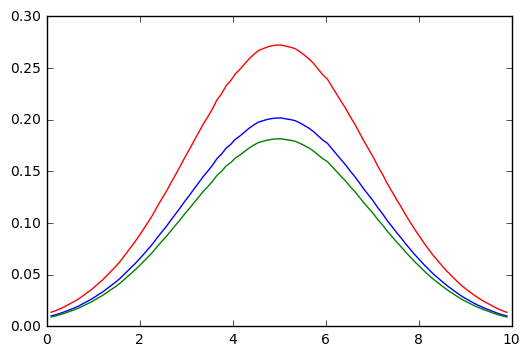

In [7]:
import matplotlib.pylab as plt
%matplotlib inline
x = np.linspace(0.1,9.9,100)
y = b.pdf(x)
yp = (b.Scale(0.9)).pdf(x)
ypp = (b.Scale(1.5)).pdf(x)
plt.plot(x,y)
plt.plot(x,yp)
plt.plot(x,ypp)


In [8]:
import scipy as sp
sp.integrate.quad(b.pdf,b.minlim,b.maxlim)

/home/brais/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


(1.348709976646281, 0.00011790450591631085)

In [9]:
b.Int

1.3499999999999999

In [10]:
c = PDF(a,2.,'linear')

In [11]:
c.Int

2.0000000000000004